In [1]:
%pip install sagemaker --upgrade --quiet 

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install -q xgboost pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import boto3
import sagemaker
import json
import joblib
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner
)
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# Setting SageMaker variables
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "fraud-detect-demo"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)

sagemaker_role = sagemaker.get_execution_role()
sagemaker_client = boto3.client("sagemaker")
read_bucket = "sagemaker-sample-files"
read_prefix = "datasets/tabular/synthetic_automobile_claims" 


# Setting S3 location for read and write operations
train_data_key = f"{read_prefix}/train.csv"
test_data_key = f"{read_prefix}/test.csv"
validation_data_key = f"{read_prefix}/validation.csv"
model_key = f"{write_prefix}/model"
output_key = f"{write_prefix}/output"


train_data_uri = f"s3://{read_bucket}/{train_data_key}"
test_data_uri = f"s3://{read_bucket}/{test_data_key}"
validation_data_uri = f"s3://{read_bucket}/{validation_data_key}"
model_uri = f"s3://{write_bucket}/{model_key}"
output_uri = f"s3://{write_bucket}/{output_key}"
estimator_output_uri = f"s3://{write_bucket}/{write_prefix}/training_jobs"
bias_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify-output/bias"
explainability_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify-output/explainability"

/opt/conda/lib/python3.12/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [9]:
tuning_job_name_prefix = "xgbtune" 
training_job_name_prefix = "xgbtrain"

xgb_model_name = "fraud-detect-xgb-model"
endpoint_name_prefix = "xgb-fraud-model-dev"
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
predictor_instance_count = 1
predictor_instance_type = "ml.m4.xlarge"
clarify_instance_count = 1
clarify_instance_type = "ml.m4.xlarge"



In [10]:
%%writefile xgboost_train.py

import argparse
import os
import joblib
import json
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters and algorithm parameters are described here
    parser.add_argument("--num_round", type=int, default=100)
    parser.add_argument("--max_depth", type=int, default=3)
    parser.add_argument("--eta", type=float, default=0.2)
    parser.add_argument("--subsample", type=float, default=0.9)
    parser.add_argument("--colsample_bytree", type=float, default=0.8)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--eval_metric", type=str, default="auc")
    parser.add_argument("--nfold", type=int, default=3)
    parser.add_argument("--early_stopping_rounds", type=int, default=3)
    

    # SageMaker specific arguments. Defaults are set in the environment variables
    # Location of input training data
    parser.add_argument("--train_data_dir", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    # Location of input validation data
    parser.add_argument("--validation_data_dir", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    # Location where trained model will be stored. Default set by SageMaker, /opt/ml/model
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    # Location where model artifacts will be stored. Default set by SageMaker, /opt/ml/output/data
    parser.add_argument("--output_data_dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    
    args = parser.parse_args()

    data_train = pd.read_csv(f"{args.train_data_dir}/train.csv")
    train = data_train.drop("fraud", axis=1)
    label_train = pd.DataFrame(data_train["fraud"])
    dtrain = xgb.DMatrix(train, label=label_train)
    
    
    data_validation = pd.read_csv(f"{args.validation_data_dir}/validation.csv")
    validation = data_validation.drop("fraud", axis=1)
    label_validation = pd.DataFrame(data_validation["fraud"])
    dvalidation = xgb.DMatrix(validation, label=label_validation)

    params = {"max_depth": args.max_depth,
              "eta": args.eta,
              "objective": args.objective,
              "subsample" : args.subsample,
              "colsample_bytree":args.colsample_bytree
             }
    
    num_boost_round = args.num_round
    nfold = args.nfold
    early_stopping_rounds = args.early_stopping_rounds
    
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds,
        metrics=["auc"],
        seed=42,
    )
    
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))
    
    train_pred = model.predict(dtrain)
    validation_pred = model.predict(dvalidation)
    
    train_auc = roc_auc_score(label_train, train_pred)
    validation_auc = roc_auc_score(label_validation, validation_pred)
    
    print(f"[0]#011train-auc:{train_auc:.2f}")
    print(f"[0]#011validation-auc:{validation_auc:.2f}")

    metrics_data = {"hyperparameters" : params,
                    "binary_classification_metrics": {"validation:auc": {"value": validation_auc},
                                                      "train:auc": {"value": train_auc}
                                                     }
                   }
              
    # Save the evaluation metrics to the location specified by output_data_dir
    metrics_location = args.output_data_dir + "/metrics.json"
    
    # Save the model to the location specified by model_dir
    model_location = args.model_dir + "/xgboost-model"

    with open(metrics_location, "w") as f:
        json.dump(metrics_data, f)

    with open(model_location, "wb") as f:
        joblib.dump(model, f)


Overwriting xgboost_train.py


In [11]:
# SageMaker estimator

# Set static hyperparameters that will not be tuned
static_hyperparams = {  
                        "eval_metric" : "auc",
                        "objective": "binary:logistic",
                        "num_round": "5"
                      }

xgb_estimator = XGBoost(
                        entry_point="xgboost_train.py",
                        output_path=estimator_output_uri,
                        code_location=estimator_output_uri,
                        hyperparameters=static_hyperparams,
                        role=sagemaker_role,
                        instance_count=train_instance_count,
                        instance_type=train_instance_type,
                        framework_version="1.3-1",
                        base_job_name=training_job_name_prefix
                    )

[04/29/25 04:54:59] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=582440;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=586406;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m4.xlarge.                    ]8;id=703458;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=839111;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [12]:
# Setting ranges of hyperparameters to be tuned
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "subsample": ContinuousParameter(0.7, 0.95),
    "colsample_bytree": ContinuousParameter(0.7, 0.95),
    "max_depth": IntegerParameter(1, 5)
}

In [13]:
objective_metric_name = "validation:auc"

# Setting up tuner object
tuner_config_dict = {
                     "estimator" : xgb_estimator,
                     "max_jobs" : 5,
                     "max_parallel_jobs" : 2,
                     "objective_metric_name" : objective_metric_name,
                     "hyperparameter_ranges" : hyperparameter_ranges,
                     "base_tuning_job_name" : tuning_job_name_prefix,
                     "strategy" : "Random"
                    }
tuner = HyperparameterTuner(**tuner_config_dict)

In [14]:
# Setting the input channels for tuning job
s3_input_train = TrainingInput(s3_data="s3://{}/{}".format(read_bucket, train_data_key), content_type="csv", s3_data_type="S3Prefix")
s3_input_validation = (TrainingInput(s3_data="s3://{}/{}".format(read_bucket, validation_data_key), 
                                    content_type="csv", s3_data_type="S3Prefix")
                      )

tuner.fit(inputs={"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False)
tuner.wait()

[04/29/25 04:55:06] WARNING  No finished training job found associated with this estimator.       ]8;id=917617;file:///opt/conda/lib/python3.12/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=897291;file:///opt/conda/lib/python3.12/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name: xgbtune-250429-0455      ]8;id=65147;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=172938;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#3383\3383]8;;\

....................................................!
!


In [15]:
# Summary of tuning results ordered in descending order of performance
df_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()
df_tuner = df_tuner[df_tuner["FinalObjectiveValue"]>-float('inf')].sort_values("FinalObjectiveValue", ascending=False)
df_tuner

,colsample_bytree,eta,max_depth,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,0.744653,0.473328,3.0,0.902921,xgbtune-250429-0455-003-da36266f,Completed,0.72,2025-04-29 04:58:11+00:00,2025-04-29 04:58:45+00:00,34.0
0,0.783112,0.925674,1.0,0.743181,xgbtune-250429-0455-005-7b6618ac,Completed,0.70,2025-04-29 04:59:00+00:00,2025-04-29 04:59:34+00:00,34.0
1,0.768212,0.897930,1.0,0.779111,xgbtune-250429-0455-004-47176958,Completed,0.70,2025-04-29 04:58:12+00:00,2025-04-29 04:58:46+00:00,34.0
3,0.866513,0.933478,5.0,0.880436,xgbtune-250429-0455-002-f2081fe0,Completed,0.69,2025-04-29 04:55:54+00:00,2025-04-29 04:57:43+00:00,109.0
4,0.758616,0.128450,5.0,0.790917,xgbtune-250429-0455-001-8d4a2db4,Completed,0.65,2025-04-29 04:55:49+00:00,2025-04-29 04:57:39+00:00,110.0


In [16]:
tuner_job_info = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)

model_matches = sagemaker_client.list_models(NameContains=xgb_model_name)["Models"]

if not model_matches:
    _ = sess.create_model_from_job(
            name=xgb_model_name,
            training_job_name=tuner_job_info['BestTrainingJob']["TrainingJobName"],
            role=sagemaker_role,
            image_uri=tuner_job_info['TrainingJobDefinition']["AlgorithmSpecification"]["TrainingImage"]
            )
else:

    print(f"Model {xgb_model_name} already exists.")

[04/29/25 05:01:54] INFO     Creating model with name: fraud-detect-xgb-model                       ]8;id=751398;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=196306;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

In [17]:
train_df = pd.read_csv(train_data_uri)
train_df_cols = train_df.columns.to_list()

clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=clarify_instance_count,
    instance_type=clarify_instance_type,
    sagemaker_session=sess,
)

# Data config
bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=bias_report_output_uri,
    label="fraud",
    headers=train_df_cols,
    dataset_type="text/csv",
)

# Model config
model_config = sagemaker.clarify.ModelConfig(
    model_name=xgb_model_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

# Model predictions config to get binary labels from probabilities
predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

# Bias config
bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)

[04/29/25 05:02:04] INFO     Ignoring unnecessary instance type: None.                            ]8;id=172765;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=592737;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [18]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods=["CI"],
    post_training_methods=["DPPL"]
    )

clarify_bias_job_name = clarify_processor.latest_job.name

[04/29/25 05:02:11] INFO     Analysis Config: {'dataset_type': 'text/csv', 'headers': ['fraud',     ]8;id=548456;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py\clarify.py]8;;\:]8;id=491068;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py#1987\1987]8;;\
                             'num_vehicles_involved', 'num_injuries', 'num_witnesses',                             
                             'police_report_available', 'injury_claim', 'vehicle_claim',                           
                             'total_claim_amount', 'incident_month', 'incident_day',                               
                             'incident_dow', 'incident_hour', 'customer_age', 'months_as_customer',                
                             'num_claims_past_year', 'num_insurers_past_5_years',                                  
                             'policy_deductable', 'policy_annual_premium', 'policy_liability',                     
                             'customer_education', 'auto_year', 'driver_relationship_other',                       
                             'driver_relationship_child', 'driver_relationship_spouse',                            
                             'driver_relationship_na', 'driver_relationship_self',                                 
                             'incident_type_collision', 'incident_type_break-in',                                  
                             'incident_type_theft', 'collision_type_rear', 'collision_type_side',                  
                             'collision_type_na', 'collision_type_front',                                          
                             'incident_severity_totaled', 'incident_severity_major',                               
                             'incident_severity_minor', 'authorities_contacted_fire',                              
                             'authorities_contacted_none', 'authorities_contacted_police',                         
                             'authorities_contacted_ambulance', 'policy_state_ca',                                 
                             'policy_state_az', 'policy_state_nv', 'policy_state_id',                              
                             'policy_state_wa', 'policy_state_or', 'customer_gender_other',                        
                             'customer_gender_male', 'customer_gender_female'], 'label': 'fraud',                  
                             'label_values_or_threshold': [0], 'facet': [{'name_or_index':                         
                             'customer_gender_female', 'value_or_threshold': [1]}], 'methods':                     
                             {'report': {'name': 'report', 'title': 'Analysis Report'},                            
                             'pre_training_bias': {'methods': ['CI']}, 'post_training_bias':                       
                             {'methods': ['DPPL']}}, 'predictor': {'model_name':                                   
                             'fraud-detect-xgb-model', 'instance_type': 'ml.m4.xlarge',                            
                             'initial_instance_count': 1, 'accept_type': 'text/csv'},                              
                             'probability_threshold': 0.5}                                                         

                    INFO     Creating processing-job with name Clarify-Bias-2025-04-29-05-02-11-082 ]8;id=300038;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=857560;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1575\1575]8;;\

...............................sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
We are not in a supported iso region, /bin/sh exiting gracefully with no changes.
INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing job
INFO:analyzer.data_loading.data_loader_util:Analysis config path: /opt/ml/processing/input/config/analysis_config.json
INFO:analyzer.data_loading.data_loader_util:Analysis result path: /opt/ml/processing/output
INFO:analyzer.data_loading.data_loader_util:This host is algo-1.
INFO:analyzer.data_loading.data_loader_util:This host is the leader.
INFO:analyzer.data_loading.data_loader_util:Number of hosts in the cluster is 1.
INFO:sagemaker-clarify-processing:Running Python / Pandas based analyzer.
INFO:analyzer.data_loading.data_loader_factory:Dataset type: text/csv uri: /opt/ml/processing/input/data
INFO:sage

In [19]:
# Copy bias report and view locally
!aws s3 cp s3://{write_bucket}/{write_prefix}/clarify-output/bias/report.pdf ./clarify_bias_output.pdf

download: s3://sagemaker-us-east-1-570019109389/fraud-detect-demo/clarify-output/bias/report.pdf to ./clarify_bias_output.pdf


In [20]:
explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=explainability_report_output_uri,
    label="fraud",
    headers=train_df_cols,
    dataset_type="text/csv",
)

# Use mean of train dataset as baseline data point
shap_baseline = [list(train_df.drop(["fraud"], axis=1).mean())]

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=shap_baseline,
    num_samples=500,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config
)

[04/29/25 05:32:40] INFO     Analysis Config: {'dataset_type': 'text/csv', 'headers': ['fraud',     ]8;id=988293;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py\clarify.py]8;;\:]8;id=43207;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py#1987\1987]8;;\
                             'num_vehicles_involved', 'num_injuries', 'num_witnesses',                             
                             'police_report_available', 'injury_claim', 'vehicle_claim',                           
                             'total_claim_amount', 'incident_month', 'incident_day',                               
                             'incident_dow', 'incident_hour', 'customer_age', 'months_as_customer',                
                             'num_claims_past_year', 'num_insurers_past_5_years',                                  
                             'policy_deductable', 'policy_annual_premium', 'policy_liability',                     
                             'customer_education', 'auto_year', 'driver_relationship_other',                       
                             'driver_relationship_child', 'driver_relationship_spouse',                            
                             'driver_relationship_na', 'driver_relationship_self',                                 
                             'incident_type_collision', 'incident_type_break-in',                                  
                             'incident_type_theft', 'collision_type_rear', 'collision_type_side',                  
                             'collision_type_na', 'collision_type_front',                                          
                             'incident_severity_totaled', 'incident_severity_major',                               
                             'incident_severity_minor', 'authorities_contacted_fire',                              
                             'authorities_contacted_none', 'authorities_contacted_police',                         
                             'authorities_contacted_ambulance', 'policy_state_ca',                                 
                             'policy_state_az', 'policy_state_nv', 'policy_state_id',                              
                             'policy_state_wa', 'policy_state_or', 'customer_gender_other',                        
                             'customer_gender_male', 'customer_gender_female'], 'label': 'fraud',                  
                             'predictor': {'model_name': 'fraud-detect-xgb-model', 'instance_type':                
                             'ml.m4.xlarge', 'initial_instance_count': 1, 'accept_type':                           
                             'text/csv'}, 'methods': {'report': {'name': 'report', 'title':                        
                             'Analysis Report'}, 'shap': {'use_logit': False,                                      
                             'save_local_shap_values': True, 'baseline': [[2.1085058618109254,                     
                             0.5584933898727862, 0.8685457720129708, 0.4220503866300823,                           
                             24257.121476677476, 17169.351123437555, 41426.472600115034,                           
                             6.726365677226241, 15.585682215016213, 2.645048640558743,                             
                             11.722624095784484, 44.15714642055375, 98.60688450985283,                             
                             0.08730356697430781, 1.4130705911698678, 751.0725866799701,                           
                             2925.3305063606886, 1.118233973559491, 2.531304564729359,                             
                             2015.7251184834124, 0.04065851833374907, 0.04489897730107259,                         
                             0.08505861810925418, 0.14342728860064854, 0.6859565976552756,              

[04/29/25 05:32:41] INFO     Creating processing-job with name                                      ]8;id=970300;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=418371;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1575\1575]8;;\
                             Clarify-Explainability-2025-04-29-05-32-40-948                                        

........................sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
We are not in a supported iso region, /bin/sh exiting gracefully with no changes.
INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing job
INFO:analyzer.data_loading.data_loader_util:Analysis config path: /opt/ml/processing/input/config/analysis_config.json
INFO:analyzer.data_loading.data_loader_util:Analysis result path: /opt/ml/processing/output
INFO:analyzer.data_loading.data_loader_util:This host is algo-1.
INFO:analyzer.data_loading.data_loader_util:This host is the leader.
INFO:analyzer.data_loading.data_loader_util:Number of hosts in the cluster is 1.
INFO:sagemaker-clarify-processing:Running Python / Pandas based analyzer.
INFO:analyzer.data_loading.data_loader_factory:Dataset type: text/csv uri: /opt/ml/processing/input/data
INFO:sagemaker-c

In [21]:
# Copy explainability report and view
!aws s3 cp s3://{write_bucket}/{write_prefix}/clarify-output/explainability/report.pdf ./clarify_explainability_output.pdf

download: s3://sagemaker-us-east-1-570019109389/fraud-detect-demo/clarify-output/explainability/report.pdf to ./clarify_explainability_output.pdf


[04/29/25 06:11:55] INFO     generated new fontManager                                         ]8;id=357843;file:///opt/conda/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=349671;file:///opt/conda/lib/python3.12/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

Example number: 100


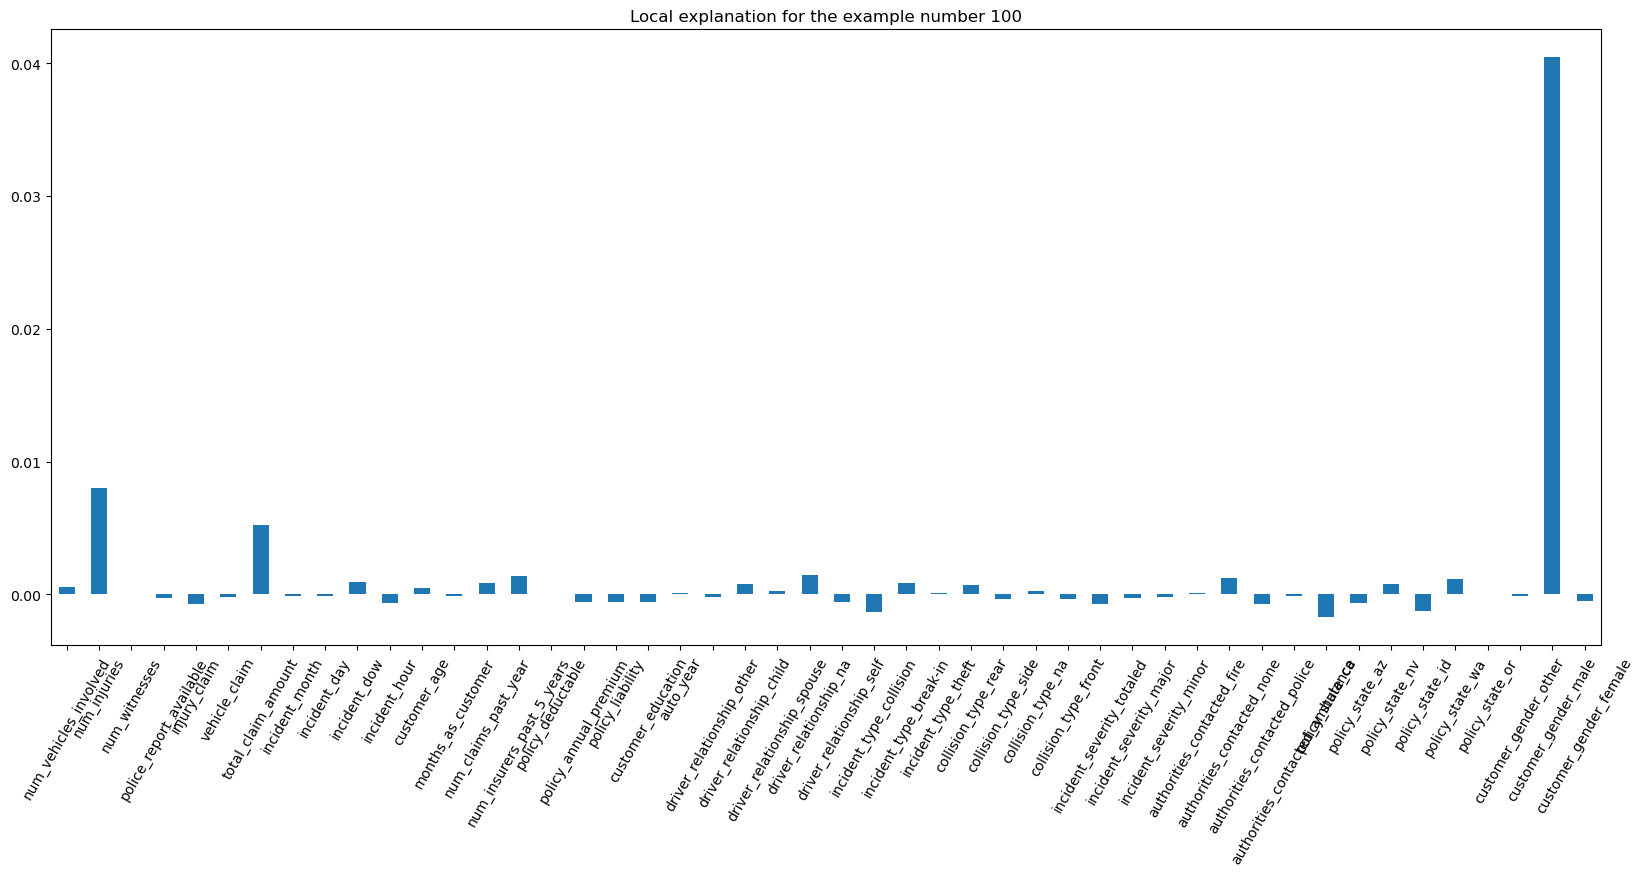

In [22]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
local_explanations_out = pd.read_csv(explainability_report_output_uri + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in 
local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 100
print("Example number:", selected_example)

local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=60, figsize=(20, 8)
);

In [23]:
best_train_job_name = tuner.best_training_job()

model_path = estimator_output_uri + '/' + best_train_job_name + '/output/model.tar.gz'
training_image = retrieve(framework="xgboost", region=region, version="1.3-1")
create_model_config = {"model_data":model_path,
                       "role":sagemaker_role,
                       "image_uri":training_image,
                       "name":endpoint_name_prefix,
                       "predictor_cls":sagemaker.predictor.Predictor
                       }
# Create a SageMaker model
model = sagemaker.model.Model(**create_model_config)

# Deploy the best model and get access to a SageMaker Predictor
predictor = model.deploy(initial_instance_count=predictor_instance_count, 
                         instance_type=predictor_instance_type,
                         serializer=CSVSerializer(),
                         deserializer=CSVDeserializer())
print(f"\nModel deployed at endpoint : {model.endpoint_name}")

[04/29/25 06:12:11] INFO     Ignoring unnecessary instance type: None.                            ]8;id=895204;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=977352;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating model with name: xgb-fraud-model-dev                          ]8;id=247696;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=782714;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/29/25 06:12:12] INFO     Creating endpoint-config with name                                     ]8;id=309213;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=389608;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#6019\6019]8;;\
                             xgb-fraud-model-dev-2025-04-29-06-12-12-200                                           

                    INFO     Creating endpoint with name                                            ]8;id=730786;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=982819;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4841\4841]8;;\
                             xgb-fraud-model-dev-2025-04-29-06-12-12-200                                           

---------!
Model deployed at endpoint : xgb-fraud-model-dev-2025-04-29-06-12-12-200


In [24]:
# Sample test data
test_df = pd.read_csv(test_data_uri)
payload = test_df.drop(["fraud"], axis=1).iloc[0].to_list()
print(f"Model predicted score : {float(predictor.predict(payload)[0][0]):.3f}, True label : {test_df['fraud'].iloc[0]}")

Model predicted score : 0.044, True label : 0
